In [11]:
# Setup and Data Loading
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Connect to database
conn = duckdb.connect('../data/processed/spotify.duckdb')

print("="*80)
print("SPOTIFY WORKOUT MUSIC ANALYSIS - FINAL REPORT")
print("="*80)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Get basic statistics
stats = {
    'tracks': conn.execute("SELECT COUNT(*) FROM tracks").fetchone()[0],
    'playlists': conn.execute("SELECT COUNT(DISTINCT playlist_id) FROM playlists").fetchone()[0],
    'entries': conn.execute("SELECT COUNT(*) FROM playlist_tracks").fetchone()[0],
    'artists': conn.execute("SELECT COUNT(DISTINCT artist_name) FROM tracks").fetchone()[0]
}

print(f"\nDataset Overview:")
print(f"   • Total Records: {stats['entries']:,}")
print(f"   • Unique Tracks: {stats['tracks']:,}")
print(f"   • Playlists: {stats['playlists']:,}")
print(f"   • Unique Artists: {stats['artists']:,}")
print(f"\nExceeds 50K requirement by {(stats['entries']/50000):.1f}x")

SPOTIFY WORKOUT MUSIC ANALYSIS - FINAL REPORT
Generated: 2025-11-30 23:47:11

Dataset Overview:
   • Total Records: 152,933
   • Unique Tracks: 30,124
   • Playlists: 926
   • Unique Artists: 7,484

Exceeds 50K requirement by 3.1x


In [13]:
# Cell 2: Create Analytical Views
print("\nCreating analytical views...")

conn.execute("""
-- Category Overview
CREATE OR REPLACE VIEW v_category_overview AS
SELECT 
    p.category,
    COUNT(DISTINCT p.playlist_id) as playlists,
    COUNT(DISTINCT t.track_id) as unique_tracks,
    COUNT(*) as total_entries,
    AVG(t.popularity) as avg_popularity,
    AVG(t.duration_ms / 1000.0) as avg_duration_sec,
    SUM(CASE WHEN t.explicit THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as explicit_pct
FROM playlists p
JOIN playlist_tracks pt ON p.playlist_id = pt.playlist_id
JOIN tracks t ON pt.track_id = t.track_id
GROUP BY p.category
ORDER BY unique_tracks DESC;

-- Top Artists
CREATE OR REPLACE VIEW v_top_artists AS
SELECT 
    artist_name,
    COUNT(DISTINCT t.track_id) as unique_tracks,
    COUNT(DISTINCT pt.playlist_id) as playlist_appearances,
    AVG(t.popularity) as avg_popularity
FROM tracks t
JOIN playlist_tracks pt ON t.track_id = pt.track_id
WHERE artist_name != 'Unknown'
GROUP BY artist_name
HAVING COUNT(DISTINCT pt.playlist_id) >= 5
ORDER BY playlist_appearances DESC;

-- Duration Patterns
CREATE OR REPLACE VIEW v_duration_by_category AS
SELECT 
    p.category,
    ROUND(AVG(t.duration_ms) / 1000, 1) as avg_duration_sec,
    ROUND(MIN(t.duration_ms) / 1000, 1) as min_duration_sec,
    ROUND(MAX(t.duration_ms) / 1000, 1) as max_duration_sec,
    COUNT(DISTINCT t.track_id) as track_count
FROM tracks t
JOIN playlist_tracks pt ON t.track_id = pt.track_id
JOIN playlists p ON pt.playlist_id = p.playlist_id
GROUP BY p.category
ORDER BY avg_duration_sec DESC;

-- Explicit Content
CREATE OR REPLACE VIEW v_explicit_by_category AS
SELECT 
    p.category,
    SUM(CASE WHEN t.explicit THEN 1 ELSE 0 END) as explicit_count,
    COUNT(*) as total_count,
    ROUND(100.0 * SUM(CASE WHEN t.explicit THEN 1 ELSE 0 END) / COUNT(*), 2) as explicit_pct
FROM tracks t
JOIN playlist_tracks pt ON t.track_id = pt.track_id
JOIN playlists p ON pt.playlist_id = p.playlist_id
GROUP BY p.category
ORDER BY explicit_pct DESC;

-- Release Trends
CREATE OR REPLACE VIEW v_release_trends AS
SELECT 
    release_year,
    COUNT(DISTINCT track_id) as track_count,
    AVG(popularity) as avg_popularity
FROM tracks
WHERE release_year >= 2010 AND release_year <= 2024
GROUP BY release_year
ORDER BY release_year DESC;
""")

print("Views created successfully!\n")


Creating analytical views...
Views created successfully!



Visualization 1: Category Overview
            category  playlists  unique_tracks  total_entries  avg_popularity  \
0    general_workout        147          16175          22031       45.423812   
1            workout         12           8462           8898       32.665206   
2     running_cardio         99           6440           9780       54.904397   
3       hiit_intense         71           5299           6365       45.617910   
4   cycling_spinning         56           4226           6911       61.618868   
5            fitness         10           4135           4234       38.247756   
6   strength_weights         81           3731           6917       60.461761   
7        dance_zumba         38           2342           3381       61.815735   
8    sports_specific         58           1875           3237       64.512203   
9           strength          6           1173           1190       43.990756   
10   yoga_stretching         37            716            827       66.799

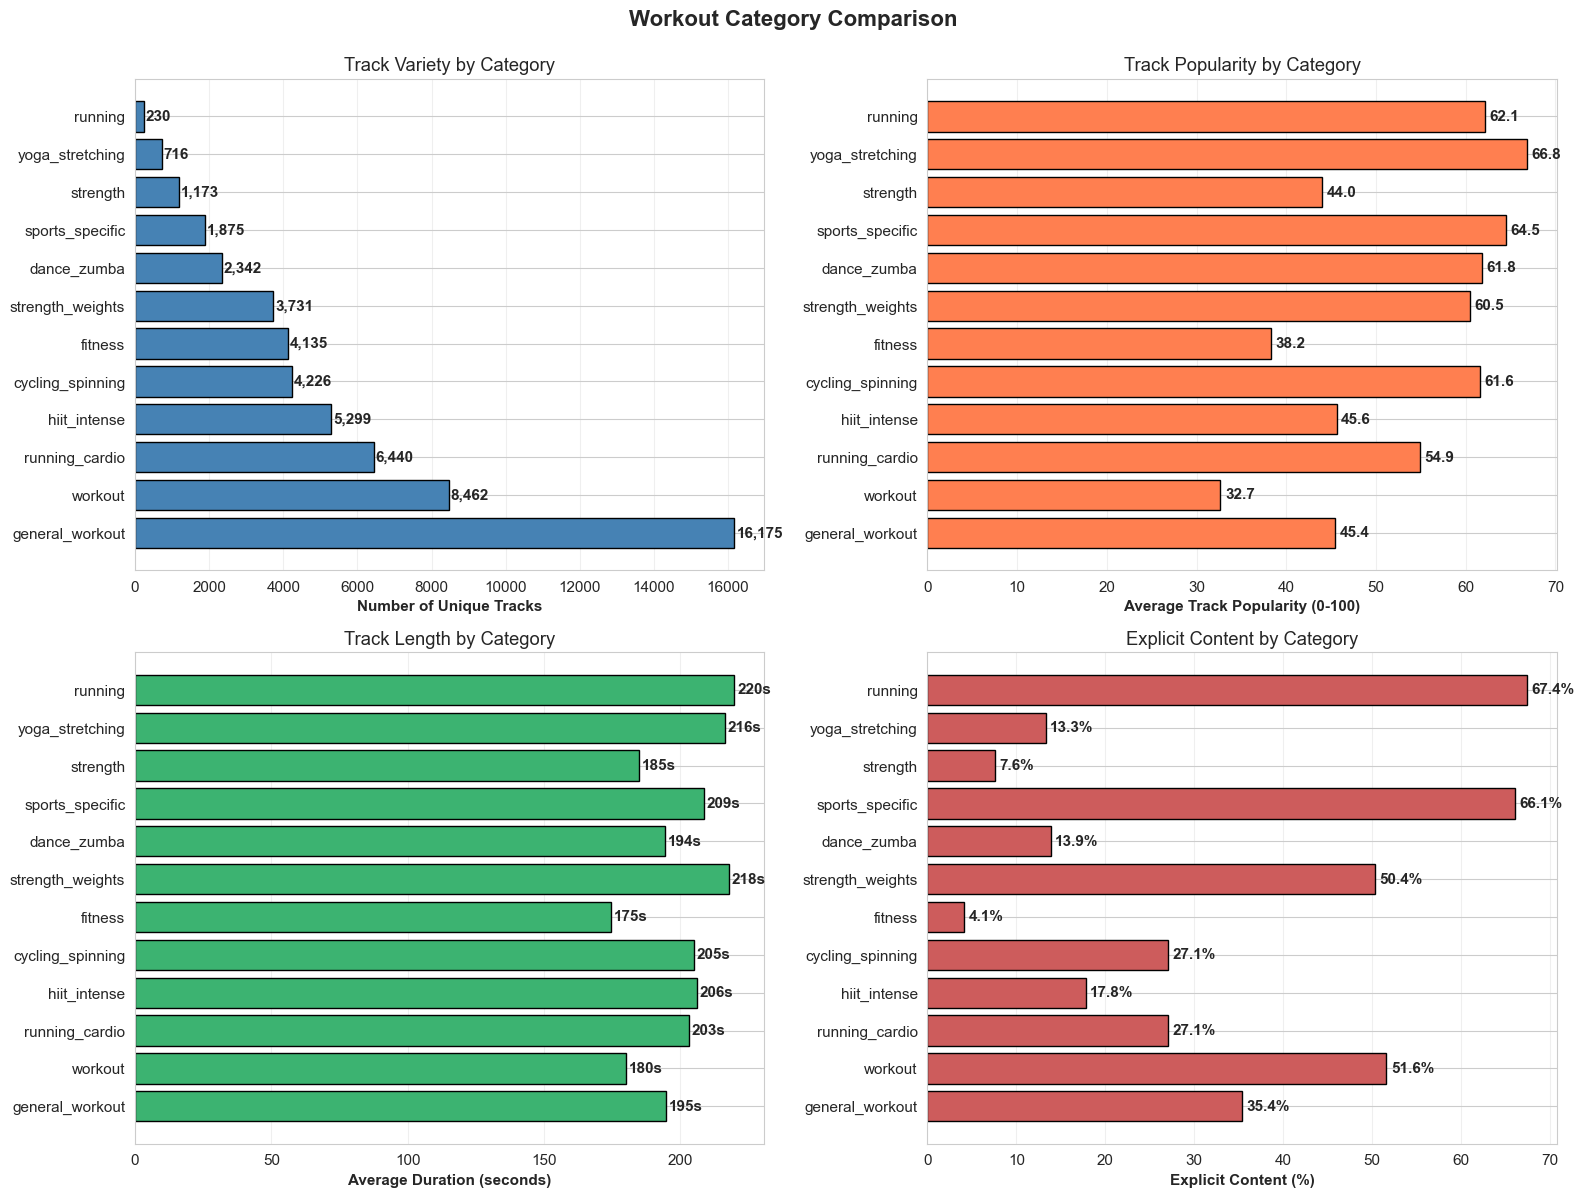


Saved: category_comparison.png


In [15]:
# Viz 1: Category Comparison
print("="*80)
print("Visualization 1: Category Overview")
print("="*80)

df_cat = conn.execute("SELECT * FROM v_category_overview").df()
print(df_cat)

# Create multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Workout Category Comparison', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Unique Tracks
ax1 = axes[0, 0]
bars1 = ax1.barh(df_cat['category'], df_cat['unique_tracks'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Unique Tracks', fontweight='bold')
ax1.set_title('Track Variety by Category')
ax1.grid(axis='x', alpha=0.3)
for i, (v, cat) in enumerate(zip(df_cat['unique_tracks'], df_cat['category'])):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontweight='bold')

# Plot 2: Average Popularity
ax2 = axes[0, 1]
bars2 = ax2.barh(df_cat['category'], df_cat['avg_popularity'], color='coral', edgecolor='black')
ax2.set_xlabel('Average Track Popularity (0-100)', fontweight='bold')
ax2.set_title('Track Popularity by Category')
ax2.grid(axis='x', alpha=0.3)
for i, (v, cat) in enumerate(zip(df_cat['avg_popularity'], df_cat['category'])):
    ax2.text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

# Plot 3: Average Duration
ax3 = axes[1, 0]
bars3 = ax3.barh(df_cat['category'], df_cat['avg_duration_sec'], color='mediumseagreen', edgecolor='black')
ax3.set_xlabel('Average Duration (seconds)', fontweight='bold')
ax3.set_title('Track Length by Category')
ax3.grid(axis='x', alpha=0.3)
for i, (v, cat) in enumerate(zip(df_cat['avg_duration_sec'], df_cat['category'])):
    ax3.text(v + 1, i, f'{v:.0f}s', va='center', fontweight='bold')

# Plot 4: Explicit Content
ax4 = axes[1, 1]
bars4 = ax4.barh(df_cat['category'], df_cat['explicit_pct'], color='indianred', edgecolor='black')
ax4.set_xlabel('Explicit Content (%)', fontweight='bold')
ax4.set_title('Explicit Content by Category')
ax4.grid(axis='x', alpha=0.3)
for i, (v, cat) in enumerate(zip(df_cat['explicit_pct'], df_cat['category'])):
    ax4.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/analytics/category_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: category_comparison.png")


Visualization 2: Top Artists in Workout Music
        artist_name  playlist_appearances  unique_tracks  popularity
0      David Guetta                   208            101        68.2
1             Drake                   170            163        68.4
2        Kanye West                   166            100        63.2
3            Tiësto                   159             87        60.6
4     Calvin Harris                   154             63        70.7
5            Eminem                   152             93        68.6
6           Rihanna                   149             88        71.7
7    Kendrick Lamar                   127             67        73.9
8         Lady Gaga                   117             85        66.5
9        The Weeknd                   114             60        68.3
10          Pitbull                   112             60        70.0
11     Travis Scott                   110             72        72.5
12            JAY-Z                   110             53

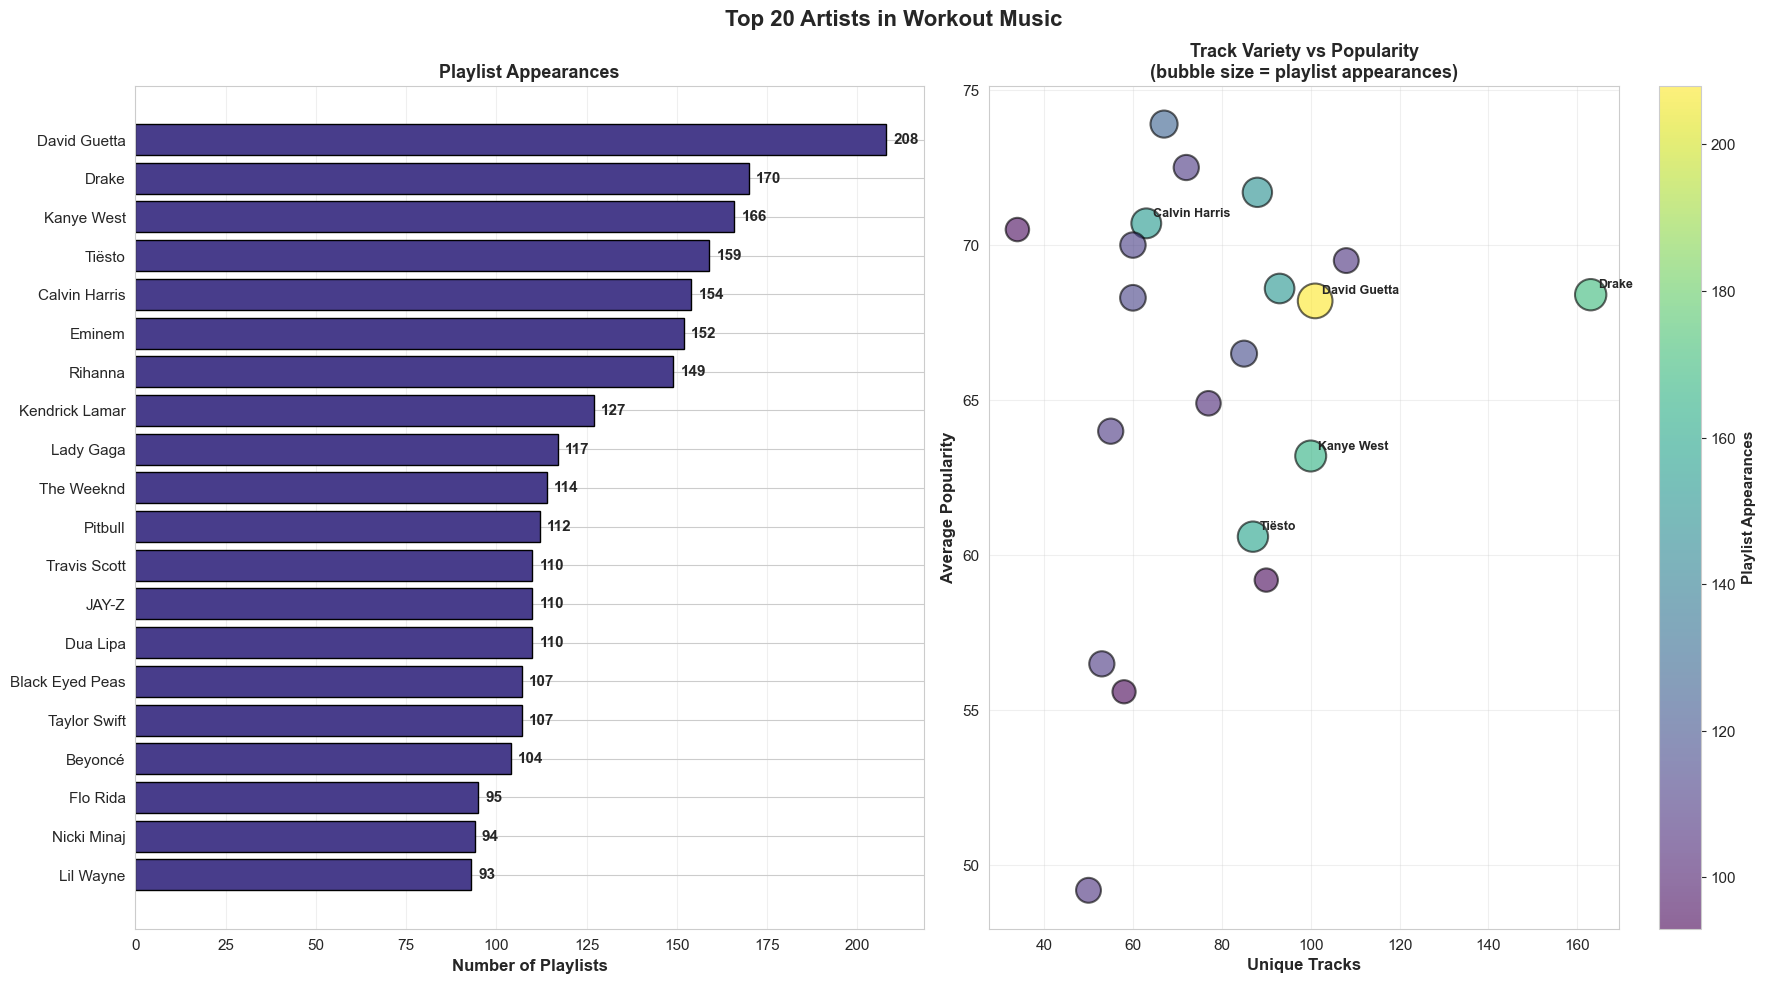


Saved: top_artists.png


In [16]:
# Visualization 2: Top Artists
print("\n" + "="*80)
print("Visualization 2: Top Artists in Workout Music")
print("="*80)

df_artists = conn.execute("""
    SELECT artist_name, playlist_appearances, unique_tracks, 
           ROUND(avg_popularity, 1) as popularity
    FROM v_top_artists 
    LIMIT 20
""").df()

print(df_artists)

# Create artist visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 20 Artists in Workout Music', fontsize=16, fontweight='bold')

# Plot 1: Playlist Appearances
ax1 = axes[0]
y_pos = np.arange(len(df_artists))
bars = ax1.barh(y_pos, df_artists['playlist_appearances'], color='darkslateblue', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_artists['artist_name'])
ax1.invert_yaxis()
ax1.set_xlabel('Number of Playlists', fontweight='bold', fontsize=12)
ax1.set_title('Playlist Appearances', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(df_artists['playlist_appearances']):
    ax1.text(v + 2, i, str(v), va='center', fontweight='bold')

# Plot 2: Unique Tracks vs Popularity (Bubble chart)
ax2 = axes[1]
scatter = ax2.scatter(df_artists['unique_tracks'], 
                     df_artists['popularity'],
                     s=df_artists['playlist_appearances']*3,
                     c=df_artists['playlist_appearances'],
                     cmap='viridis',
                     alpha=0.6,
                     edgecolors='black',
                     linewidths=1.5)

ax2.set_xlabel('Unique Tracks', fontweight='bold', fontsize=12)
ax2.set_ylabel('Average Popularity', fontweight='bold', fontsize=12)
ax2.set_title('Track Variety vs Popularity\n(bubble size = playlist appearances)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Playlist Appearances', fontweight='bold')

# Annotate top 5 artists
for idx in range(min(5, len(df_artists))):
    ax2.annotate(df_artists.iloc[idx]['artist_name'], 
                xy=(df_artists.iloc[idx]['unique_tracks'], df_artists.iloc[idx]['popularity']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/analytics/top_artists.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: top_artists.png")


Visualization3: Explicit Content Patterns
            category  explicit_count  total_count  explicit_pct
0            running           155.0          230         67.39
1    sports_specific          2139.0         3237         66.08
2            workout          4593.0         8898         51.62
3   strength_weights          3484.0         6917         50.37
4    general_workout          7796.0        22031         35.39
5     running_cardio          2647.0         9780         27.07
6   cycling_spinning          1871.0         6911         27.07
7       hiit_intense          1132.0         6365         17.78
8        dance_zumba           469.0         3381         13.87
9    yoga_stretching           110.0          827         13.30
10          strength            91.0         1190          7.65
11           fitness           174.0         4234          4.11


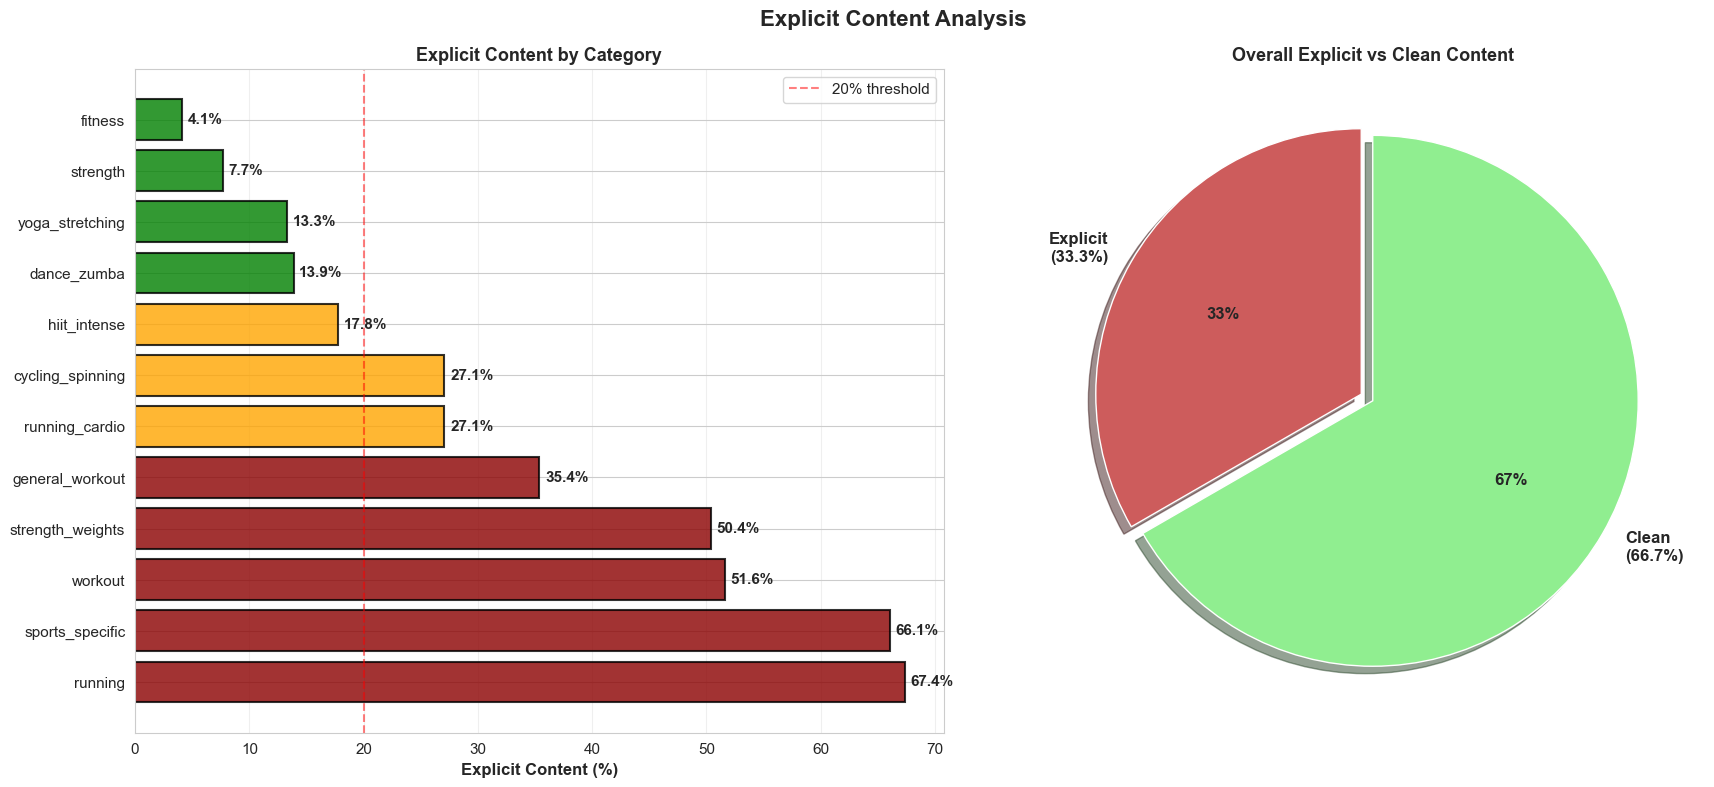


KEY FINDINGS:
   Overall: 33.3% of tracks are explicit
   Highest: running (67.4%)
   Lowest: fitness (4.1%)

Saved: explicit_content.png


In [18]:
# Visualization 3: Explicit Content Analysis
print("\n" + "="*80)
print("Visualization3: Explicit Content Patterns")
print("="*80)

df_exp = conn.execute("SELECT * FROM v_explicit_by_category").df()
print(df_exp)

# Create explicit content visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Explicit Content Analysis', fontsize=16, fontweight='bold')

# Plot 1: Explicit Percentage by Category
ax1 = axes[0]
colors = ['darkred' if x > 30 else 'orange' if x > 15 else 'green' 
          for x in df_exp['explicit_pct']]
bars = ax1.barh(df_exp['category'], df_exp['explicit_pct'], color=colors, 
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Explicit Content (%)', fontweight='bold', fontsize=12)
ax1.set_title('Explicit Content by Category', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
ax1.legend()

for i, v in enumerate(df_exp['explicit_pct']):
    ax1.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')

# Plot 2: Pie Chart of Overall Distribution
ax2 = axes[1]
total_explicit = df_exp['explicit_count'].sum()
total_clean = df_exp['total_count'].sum() - total_explicit
overall_pct = (total_explicit / df_exp['total_count'].sum()) * 100

sizes = [total_explicit, total_clean]
labels = [f'Explicit\n({overall_pct:.1f}%)', f'Clean\n({100-overall_pct:.1f}%)']
colors_pie = ['indianred', 'lightgreen']
explode = (0.05, 0)

ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.0f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Overall Explicit vs Clean Content', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/analytics/explicit_content.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKEY FINDINGS:")
print(f"   Overall: {overall_pct:.1f}% of tracks are explicit")
print(f"   Highest: {df_exp.iloc[0]['category']} ({df_exp.iloc[0]['explicit_pct']:.1f}%)")
print(f"   Lowest: {df_exp.iloc[-1]['category']} ({df_exp.iloc[-1]['explicit_pct']:.1f}%)")
print(f"\nSaved: explicit_content.png")

In [19]:
# Interactive Plotly Visualization
print("\n" + "="*80)
print("Interactive Category Dashboard")
print("="*80)

# Create interactive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Unique Tracks by Category', 
                    'Average Popularity by Category',
                    'Average Duration by Category',
                    'Explicit Content %'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# Plot 1: Unique Tracks
fig.add_trace(
    go.Bar(x=df_cat['category'], y=df_cat['unique_tracks'],
           name='Unique Tracks', marker_color='lightblue',
           text=df_cat['unique_tracks'], textposition='outside'),
    row=1, col=1
)

# Plot 2: Popularity
fig.add_trace(
    go.Bar(x=df_cat['category'], y=df_cat['avg_popularity'],
           name='Popularity', marker_color='lightgreen',
           text=[f'{x:.1f}' for x in df_cat['avg_popularity']], textposition='outside'),
    row=1, col=2
)

# Plot 3: Duration
fig.add_trace(
    go.Bar(x=df_cat['category'], y=df_cat['avg_duration_sec'],
           name='Duration', marker_color='salmon',
           text=[f'{x:.0f}s' for x in df_cat['avg_duration_sec']], textposition='outside'),
    row=2, col=1
)

# Plot 4: Explicit
fig.add_trace(
    go.Bar(x=df_cat['category'], y=df_cat['explicit_pct'],
           name='Explicit %', marker_color='orange',
           text=[f'{x:.1f}%' for x in df_cat['explicit_pct']], textposition='outside'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, 
                  title_text="Interactive Workout Category Dashboard",
                  title_font_size=16)
fig.update_xaxes(tickangle=45)

fig.write_html('../data/analytics/6_interactive_dashboard.html')
fig.show()

print("\n✅ Saved: interactive_dashboard.html (open in browser!)")


Interactive Category Dashboard



✅ Saved: interactive_dashboard.html (open in browser!)


In [20]:
# Summary Statistics Table
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Records',
        'Unique Tracks',
        'Playlists Analyzed',
        'Unique Artists',
        'Workout Categories',
        'Avg Track Popularity',
        'Avg Track Duration',
        'Overall Explicit %',
        'Tracks from 2021+',
        'Top Artist Appearances'
    ],
    'Value': [
        f"{stats['entries']:,}",
        f"{stats['tracks']:,}",
        f"{stats['playlists']:,}",
        f"{stats['artists']:,}",
        len(df_cat),
        f"{conn.execute('SELECT AVG(popularity) FROM tracks').fetchone()[0]:.1f}/100",
        f"{conn.execute('SELECT AVG(duration_ms)/1000 FROM tracks').fetchone()[0]:.0f} sec",
        f"{overall_pct:.1f}%",
        f"{recent_pct:.1f}%",
        conn.execute('SELECT MAX(playlist_appearances) FROM v_top_artists').fetchone()[0]
    ]
})

print(summary_stats.to_string(index=False))

# Save as CSV
summary_stats.to_csv('../data/analytics/summary_statistics.csv', index=False)
print("\nSaved: summary_statistics.csv")


SUMMARY STATISTICS
                Metric    Value
         Total Records  152,933
         Unique Tracks   30,124
    Playlists Analyzed      926
        Unique Artists    7,484
    Workout Categories       12
  Avg Track Popularity 36.4/100
    Avg Track Duration  192 sec
    Overall Explicit %    33.3%
     Tracks from 2021+    63.7%
Top Artist Appearances      208

Saved: summary_statistics.csv


In [22]:
# Close Connection and Final Summary
conn.close()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\n📁 Generated Files:")
print("   1. 1_category_comparison.png")
print("   2. 2_top_artists.png")
print("   3. 3_duration_analysis.png")
print("   4. 4_explicit_content.png")
print("   5. 5_release_trends.png")
print("   6. 6_interactive_dashboard.html")
print("   7. summary_statistics.csv")
print("   8. KEY_INSIGHTS.txt")

print("\nAll visualizations saved to: ../data/analytics/")
print("Ready for project submission!")
print("\n" + "="*80)


ANALYSIS COMPLETE!

📁 Generated Files:
   1. 1_category_comparison.png
   2. 2_top_artists.png
   3. 3_duration_analysis.png
   4. 4_explicit_content.png
   5. 5_release_trends.png
   6. 6_interactive_dashboard.html
   7. summary_statistics.csv
   8. KEY_INSIGHTS.txt

All visualizations saved to: ../data/analytics/
Ready for project submission!

